# Force curves versus velocity for an $F=1 \rightarrow F'=1$ system
In this notebook, we simulate cooling for an $F=1 \rightarrow F'=1$ system. In particular, we reproduce figures from [NJP 18, 123017 (2016)](https://doi.org/10.1088/1367-2630/18/12/123017).

In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

We'll first define a few physical constants needed for this simulation. 

In [3]:
λ = 1; Γ = 2π; m = 1; k = 2π / λ;

Using `QuantumStates`, we can create both the ground states (`F1_lower`) and excited states (`F1_upper`) using the `AngularMomentumState` type, which is a state type of "bare" angular momentum states $|F,m\rangle$.

In [4]:
H_operator = :(
    T * L +
    B_z * (Zeeman_L0 + 2 * Zeeman_L1)
)
parameters = @params begin
    T = 10.
    B_z = 0.
end

# Create basis states
QN_bounds = (L = 0, N = 1)
F1_lower = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
F1_upper = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

ground_states = F1_lower
excited_states = F1_upper
basis = [ground_states; excited_states]

H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
evaluate!(H)
QuantumStates.solve!(H)
;

The transition dipole moments `d` and the magnetic moments `d_m` are calculated using `QuantumStates.get_tdms_two_bases`:

In [5]:
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
;

In [6]:
# d_ge = get_tdms_two_bases(ground_states, excited_states, TDM)
# d = zeros(length(H.states), length(H.states), 3)
# d[1:length(ground_states), (length(ground_states)+1):length(H.states), :] .= d_ge
# d[(length(ground_states)+1):length(H.states), 1:length(ground_states), :] .= permutedims(d_ge, (2,1,3))
# ;

We now define the lasers, along with the detuning $\Delta$ and saturation $s$. Note that all lasers have the polarization $\sigma^+$ in their own frame, which is rotated to the $\hat{z}$ axis using `rotate_pol`. (Technically, the rotation is performed _from_ the $\hat{z}$ axis _to_ the axis of the given laser's $k$-vector because the variable $\sigma^+$ is defined relative to the $\hat{z}$ axis.)

In [7]:
# Laser parameters
Δ = -2.5Γ
s = 1.0

# Frequency of the lasers (in angular frequency units)
ω_F1_to_F1 = 2π * H.parameters.T + Δ

ϵ_(ϵ1) = t -> ϵ1

ϕ = π/2

lin = cart2sph * [1,0,0]
linϕ = cart2sph * [cos(ϕ), sin(ϕ), 0]
lin_z = [0,1,0]

# k̂ = +x̂; ϵ1 = ϵ_(cart2sph * [0,1,0]); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(cart2sph * [0,0,1]); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(cart2sph * [1,0,0]); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(cart2sph * [0,0,1]); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(cart2sph * lin ); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(cart2sph * linϕ); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# xp_ϵ = cart2sph * [0, -im, -1] / √2
# xm_ϵ = cart2sph * [0, -im, +1] / √2
# yp_ϵ = cart2sph * [-1, 0, -im] / √2
# ym_ϵ = cart2sph * [+1, 0, -im] / √2
# zp_ϵ = cart2sph * [-1, -im, 0] / √2
# zm_ϵ = cart2sph * [+1, -im, 0] / √2

# k̂ = +x̂; ϵ1 = ϵ_(xp_ϵ); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(xm_ϵ); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(yp_ϵ); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(ym_ϵ); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
# lasers =  [laser3, laser4]
# lasers =  [laser5, laser6]

# k̂ = +ẑ; ϵ = ϵ_( rotate_pol((σ⁺+σ⁻)/√2, k̂)); laser_ = Field(k̂, ϵ, ω_F1_to_F1, s)
# lasers = [laser_]

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(-rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_( rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(-rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

In [8]:
k̂ = +x̂; rotate_pol(σ⁺, k̂) |> display
k̂ = -x̂; -rotate_pol(σ⁺, k̂) |> display

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
   0.49999999999999994 + 0.0im
 4.329780281177467e-17 - 0.7071067811865476im
                  -0.5 - 6.123233995736766e-17im

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
   -0.49999999999999994 - 0.0im
 -4.329780281177467e-17 - 0.7071067811865476im
                    0.5 - 6.123233995736766e-17im

In [9]:
k̂ = +ŷ; rotate_pol(σ⁺, k̂) |> display
k̂ = -ŷ; rotate_pol(σ⁺, k̂) |> display

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 -0.49999999999999994 - 6.123233995736765e-17im
   0.7071067811865476 - 2.465190328815662e-32im
                 -0.5 + 6.123233995736766e-17im

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 -0.49999999999999994 + 6.123233995736765e-17im
  -0.7071067811865476 + 8.659560562354932e-17im
                 -0.5 + 6.123233995736766e-17im

In [10]:
k̂ = +x̂; -im .* rotate_pol(σ⁺, k̂) |> display
k̂ = -x̂; -im .* rotate_pol(σ⁺, k̂) |> display

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
                    0.0 - 0.49999999999999994im
    -0.7071067811865476 - 4.329780281177467e-17im
 -6.123233995736766e-17 + 0.5im

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
                   0.0 - 0.49999999999999994im
    0.7071067811865476 - 4.329780281177467e-17im
 6.123233995736766e-17 + 0.5im

In [11]:
k̂ = +ŷ; -rotate_pol(σ⁺, k̂) |> display
k̂ = -ŷ; -rotate_pol(σ⁺, k̂) |> display

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 0.49999999999999994 + 6.123233995736765e-17im
 -0.7071067811865476 + 2.465190328815662e-32im
                 0.5 - 6.123233995736766e-17im

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 0.49999999999999994 - 6.123233995736765e-17im
  0.7071067811865476 - 8.659560562354932e-17im
                 0.5 - 6.123233995736766e-17im

In [12]:
k̂ = +ŷ; -rotate_pol(σ⁻, k̂) |> display
k̂ = -ŷ; -rotate_pol(σ⁻, k̂) |> display

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 0.5000000000000001 + 6.123233995736766e-17im
 0.7071067811865476 + 2.465190328815662e-32im
                0.5 - 6.123233995736766e-17im

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
  0.5000000000000001 + 6.123233995736766e-17im
 -0.7071067811865476 - 8.659560562354932e-17im
                 0.5 + 6.123233995736766e-17im

In [13]:
k̂ = +ẑ; rotate_pol(σ⁺, k̂) |> display
k̂ = -ẑ; rotate_pol(σ⁺, k̂) |> display

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im

3-element StaticArraysCore.SVector{3, ComplexF64} with indices SOneTo(3):
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

Before computing the force across a range of velocities, let's first check that our simulation produces reasonable results for a specific set of parameters:

In [14]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-2

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 20p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [15]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.9) .* 2π
prob.p.v = (0., 0.1, 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  8.822127 seconds (13.55 M allocations: 883.190 MiB, 5.34% gc time, 99.44% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  -8.227551885300665
  12.467069468091589
 -24.85503245397178

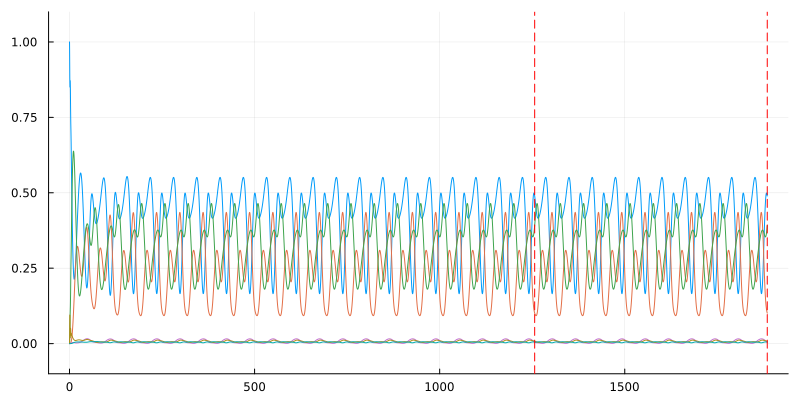

In [16]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

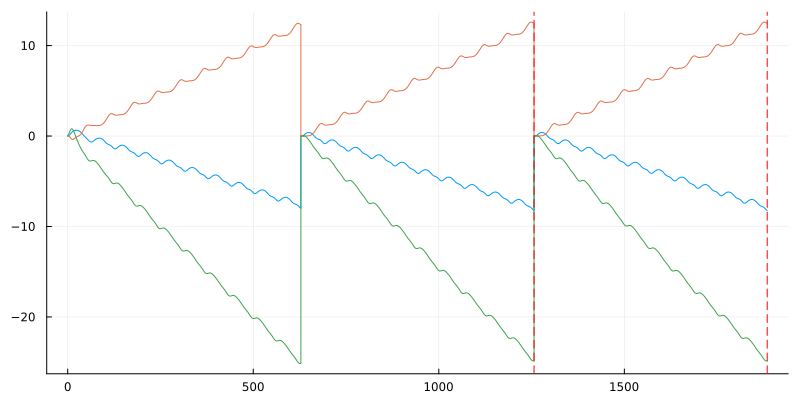

In [17]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [18]:
# E_test(x,y,z) = √2 .* [sin(k * z) - cos(k * y), sin(k * x) - cos(k * z), sin(k * y) - cos(k * x)] .* cos(p.fields.ω[1] * t_end)
E_test(x,y,z) = √2 .* [sin(z) - cos(y), sin(x) - cos(z), sin(y) - cos(x)] .* cos(p.fields.ω[1] * t_end)
# E_test(x,y,z) = √2 .* [sin(z), - cos(z), 0] .* cos(p.fields.ω[1] * t_end)

E_test (generic function with 1 method)

In [19]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus velocity

In [20]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= (scan_params[i].v, 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_params[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (f[1], 0, 0)
end
;

In [21]:
using RectiGrids
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [22]:
freq_res = 1e-1
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 5p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
;

In [23]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51m


 51.214365 seconds (8.85 M allocations: 1.605 GiB, 0.65% gc time, 59.94% compilation time)


In [24]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.178900 seconds (183.59 k allocations: 13.820 MiB, 92.20% compilation time)


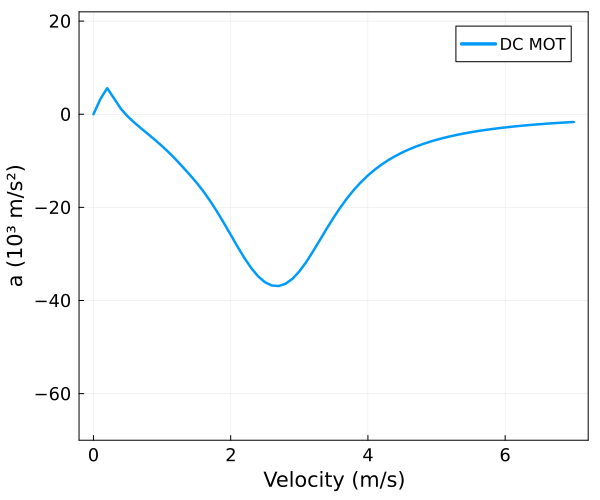

In [25]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-70,22),
    label="DC MOT",
    size=(600,500)
    )

In [26]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [27]:
freq_res = 1e-2
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 100
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [28]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


 34.660219 seconds (1.62 M allocations: 398.761 MiB, 0.20% gc time, 5.88% compilation time)


In [29]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.283338 seconds (368.51 k allocations: 66.190 MiB, 11.70% gc time, 41.73% compilation time)


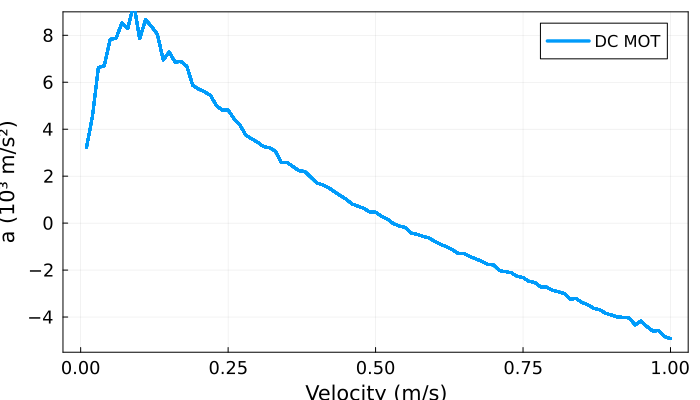

In [30]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-5.5,9),
    size=(700,400)
    )

## Laser cooling force versus magnetic field

In [46]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [47]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = 0:0.05:2.0
di = 7
rs = [(rand(), rand(), rand()) .* 2π for _ in 1:200] #vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.1) for _ in 1:200]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [ ]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress:   0%|█                                        |  ETA: 10:23:5739m

In [ ]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

In [ ]:
plot(Bs, -1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-3,23),
    size=(600,500)
    )